In [2]:
%matplotlib notebook

In [3]:
import pandas as pd
import numpy as np
import os

In [5]:
import datetime as dt
import calendar

def read_precip(fili):
    """
    Reader for precipitation files contained in the NPSNOW data set

    Arguments
    ---------
    fili - file path

    Returns
    -------
    Pandas dataframe containg precipitation data for one station
    """

    df = pd.read_csv(fili, header=None, delim_whitespace=True,
                     na_values={'amount': -9.9, 'type': -9}, 
                     names=['statid','month','day','year','amount','type'])

    isday = [row[1]['day'] <= \
             calendar.monthrange( int(row[1]['year']),int(row[1]['month']) )[1] \
             for row in df.iterrows()]
    df = df[isday] # only return rows with valid date

    df.index = [dt.datetime(int(row[1]['year']),
                            int(row[1]['month']),
                            int(row[1]['day']) ) \
                for row in df.iterrows()] # Reset index to date

    return df[['statid','amount','type']]

def read_position(fili):
    """
    Reader for position files contained in the NPSNOW dataset

    Arguments
    ---------
    fili - file path

    Returns
    -------
    Pandas dataframe containing drifting station positions
    """

    df = pd.read_csv(fili, header=None, delim_whitespace=True,
                     names=['year','month','day','hour','lat','lon'])
    df['hour'][df['hour'] == 24] = 0 #There is no hour 24
    if (df['hour'] > 24).any():
        df['hour'][df['hour'] > 24] = 12

    # This is a fix to deal with non-valid dates: e.g. 30 February
    isday = [row[1]['day'] <= \
             calendar.monthrange( int(row[1]['year']),int(row[1]['month']) )[1] \
             for row in df.iterrows()]
    df = df[isday] # only return rows with valid date

    df.index = [dt.datetime(int( '19{:2d}'.format(row[1]['year']) ),
                            int(row[1]['month']),
                            int(row[1]['day']),
                            int(row[1]['hour'])) \
                for row in df.iterrows()]
    df['lat'] = df['lat'].floordiv(1000).astype(float) + \
                df['lat'].mod(1000).divide(600)
    df['lon'] = df['lon'].floordiv(1000).astype(float) + \
                df['lon'].mod(1000).divide(600)
    
    return df[['lat','lon']]


## Plot trajectories 

In [6]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

<IPython.core.display.Javascript object>


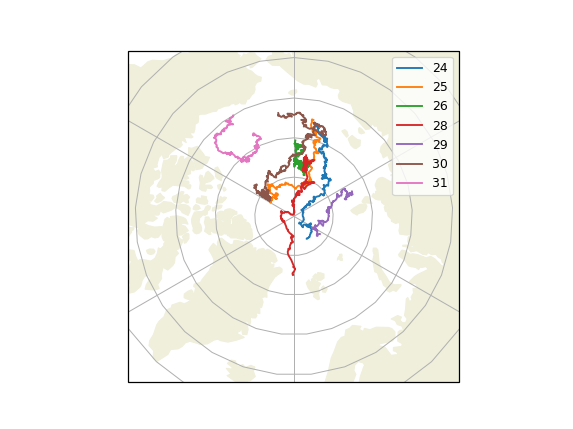

In [8]:
diri = r'C:\Users\apbarret\Documents\data\SnowOnSeaIce\NPSNOW'
map_proj = ccrs.NorthPolarStereo()

ax = plt.subplot(projection=map_proj)
ax.set_extent([-180.,180.,65.,90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.gridlines()

for id in [24,25,26,28,29,30,31]:
    fili = os.path.join(diri,'position','position.{:02d}'.format(id))
    position = read_position(fili)
    trajectory = map_proj.transform_points(ccrs.PlateCarree(), position['lon'].values, position['lat'].values)
    ax.plot(trajectory[:,0], trajectory[:,1], label=str(id))
    
plt.legend()

## Get position file and resample to daily time step

In [9]:
def llaverage(x):
    if (x['lon'].max() > 270.) and (x['lon'].min() < 90.):
        xd = x.copy()
        xd['lon'].where(xd['lon'] < 180., xd['lon']-360., inplace=True)
        result = xd.mean()
        if result['lon'] < 0.: result['lon'] = result['lon']+360.
        return result
    else:
        return x.mean()
    return

## Plot monthly means of trajectories

<IPython.core.display.Javascript object>


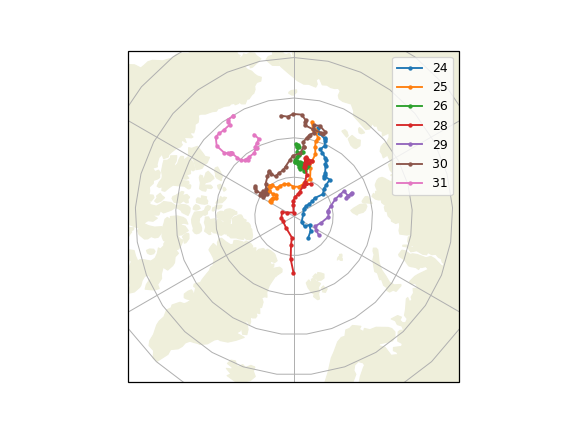

In [10]:
map_proj = ccrs.NorthPolarStereo()

ax = plt.subplot(projection=map_proj)
ax.set_extent([-180.,180.,65.,90.], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.gridlines()

for id in [24,25,26,28,29,30,31]:
    fili = os.path.join(diri,'position','position.{:02d}'.format(id))
    position = read_position(fili)
    mposition = position.resample('M').agg(llaverage)
    trajectory = map_proj.transform_points(ccrs.PlateCarree(), mposition['lon'].values, mposition['lat'].values)
    ax.plot(trajectory[:,0], trajectory[:,1], '-o', ms=2.5, label=str(id))
    
plt.legend()

plt.savefig(os.path.join(r'C:\Users\apbarret\Documents\Papers\Snow_on_seaice_precip','npp_trajectories_1979to1991.png'))

In [75]:
id = 28
fili = os.path.join(diri,'position','position.{:02d}'.format(id))
position = read_position(fili)
#position.resample('M').agg(llaverage)


In [82]:
position.resample('M').agg(llaverage)

,lat,lon
1986-05-31,80.765444,168.029444
1986-06-30,81.376140,167.164386
1986-07-31,81.862204,167.866075
1986-08-31,81.497957,164.662742
1986-09-30,81.043444,161.646944
1986-10-31,81.000699,167.565269
1986-11-30,81.678690,167.355417
1986-12-31,82.010778,167.433833
1987-01-31,80.926954,169.426437
1987-02-28,80.917963,168.574815


In [8]:
for id in [24,25,26,28,29,30,31]:
    fili = os.path.join(diri,'position','position.{:02d}'.format(id))
    position = read_position(fili)
    #position.resample('M').agg(llaverage)
    if (position['lon'].min() < 90.) & (position['lon'].max() > 270.):
        print ('{:02d} crossed prime meridian: Start year={:4d} End year={:4d}'.format(id, 
                                                                                       position.index.year.min(),
                                                                                       position.index.year.max()))
#position = read_position(fili).resample('D').mean()
#position

28 crossed prime meridian: Start year=1986 End year=1989


## Get precipitation for station

In [16]:
import glob

stationID=31
prcpFile = glob.glob(os.path.join(diri,r'precip',r'np_{:02d}_??.pre'.format(stationID)))

In [18]:
precip = pd.concat([read_precip(f) for f in prcpFile])

In [19]:
precip

,statid,amount,type
1989-01-01,31,NaN,NaN
1989-01-02,31,0.6,1.0
1989-01-03,31,NaN,NaN
1989-01-04,31,NaN,NaN
1989-01-05,31,0.2,1.0
1989-01-06,31,NaN,NaN
1989-01-07,31,NaN,NaN
1989-01-08,31,NaN,NaN
1989-01-09,31,0.2,1.0
1989-01-10,31,0.3,1.0


In [35]:
pMon = precip['amount'].resample('MS').sum()

<IPython.core.display.Javascript object>


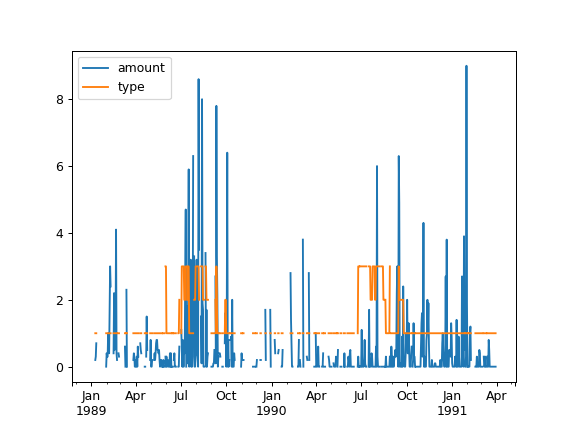

In [39]:
precip[['amount','type']].plot()

In [94]:
0.5*(80.575+81.045)

80.81